In [30]:
%matplotlib inline

In [31]:
import numpy as np
import pandas as pd

import scipy.stats as st
import matplotlib.pyplot as plt

from statsmodels.distributions.empirical_distribution import ECDF

import seaborn as sns
sns.set_style('whitegrid')

In [32]:
def preprocess_tocsv(data_string, filename):
    data_string = data_string.replace(',', '.')
    data_string = data_string.replace('\t', ',')
    data_string = data_string.replace('\n', ',')
    list_of_values = data_string.split(',')
    list_floats = [float(i) for i in list_of_values]
    array = np.array(list_floats).reshape(10, 8)
    df = pd.DataFrame(array, index = np.arange(array.shape[0]), columns=[str(i) for i in range(array.shape[1])])
    df.to_csv('../data/'+filename+'.csv')
    return df

In [33]:
group1 = pd.read_csv('group1.csv')
group2 = pd.read_csv('group2.csv')
group1 = group1.iloc[:, 1:]
group2 = group2.iloc[:, 1:]

### Обчислити вибіркові характеристики (середнє, медіана, дисперсія, інтерквартильний розмах)

In [34]:
def compute_characteristics(array, n):
    mean = array.mean()
    median = np.median(array)
    variance = np.var(array)
    percentile_length = np.percentile(array, 75) - np.percentile(array, 25)
    stat_frame = pd.DataFrame({'Mean':mean, 'Median':median, "Variance":variance,
                              "Interquartile_range":percentile_length}, index=['Group'+str(n)])
    return stat_frame

In [35]:
gr1_arr = np.ravel(group1.values)
gr2_arr = np.ravel(group2.values)
stat_gr1 = compute_characteristics(gr1_arr, 1)
stat_gr2 = compute_characteristics(gr2_arr, 2)
stat = pd.concat([stat_gr1, stat_gr2], axis=0)

In [36]:
stat

,Mean,Median,Variance,Interquartile_range
Group1,19.319875,12.575,267.865949,23.1975
Group2,29.188750,24.705,452.354351,35.8075


### Для обох груп спостережень побудувати графіки типу «вусатих коробочок»

In [37]:
idx = group1.shape[0]
groups = pd.concat([group1, group2])

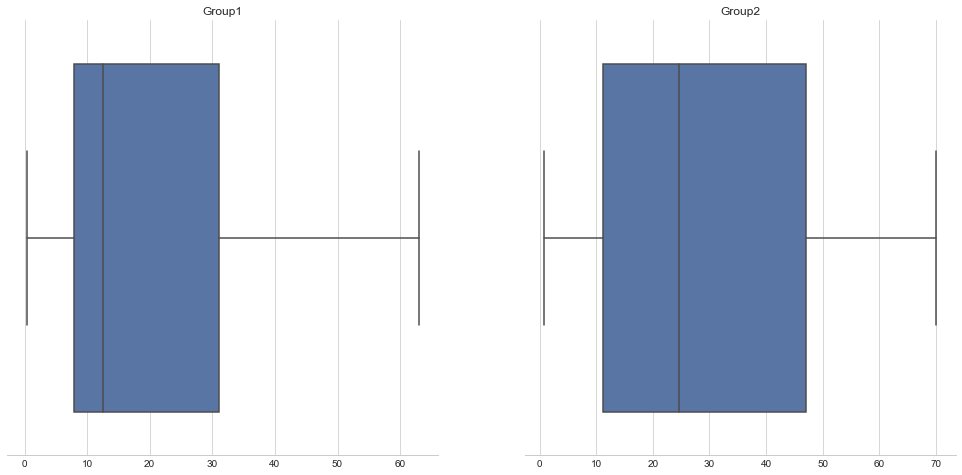

In [38]:
fig,ax = plt.subplots(figsize=(17, 8))
plt.subplot(121)
plt.title('Group1')
sns.boxplot(groups.iloc[:idx], palette='deep')
sns.despine(left=True)
plt.subplot(122)
plt.title('Group2')
sns.boxplot(groups.iloc[idx:], palette='deep');
sns.despine(left=True);

### Побудувати асимптотичні 95%-довірчі інтервали для математичного сподівання та дисперсії.

#### <center>Оцінка дисперсії</center>

![title](confidence95.png)

#### <center>Оцінка середнього</center>

![title](meanConfidence.png)


In [39]:
def confidence_intervals(sample):
    s = np.std(sample)
    n = sample.shape[0]
    SEM = s/np.sqrt(n)
    sample_mean_left, sample_mean_right =   - SEM * 1.96,np.mean(sample) + SEM * 1.96
    
    ## variance
    t_left, t_right = st.chi2.ppf(0.975, n-1), st.chi2.ppf(0.025, n-1)
    sample_var_left, sample_var_right = (n-1) * pow(s, 2) / t_left, (n-1) * pow(s, 2) / t_right

    dictionary = {
      'RightConfidenceMean':sample_mean_right, 
      'Sample_mean':np.mean(sample), 
      'LeftConfidenceMean':sample_mean_left, 
      'RightConfidenceVariance':sample_var_right,
      'SampleVariance':pow(s,2), 
      'LeftConfidenceVariance':sample_var_left
    }
    stat_df = pd.DataFrame.from_dict(dictionary, orient='index')
    return stat_df

In [40]:
stat_gr1 = confidence_intervals(gr1_arr)
stat_gr2 = confidence_intervals(gr2_arr)
stat_confs = pd.concat([stat_gr1, stat_gr2], axis=1)
stat_confs.columns = ['Group1', 'Group2']

In [41]:
stat_confs

,Group1,Group2
RightConfidenceMean,22.906367,33.849443
Sample_mean,19.319875,29.188750
LeftConfidenceMean,-3.586492,-4.660693
RightConfidenceVariance,375.809311,634.641982
SampleVariance,267.865949,452.354351
LeftConfidenceVariance,200.633907,338.817313


In [42]:
# st.bayes_mvs(gr1_arr, 0.95), st.bayes_mvs(gr2_arr, 0.95) # верификация

### Побудувати гістограму, спробувати підібрати справжню щільність за групами чи за вибіркою загалом; 

c:\programdata\miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
c:\programdata\miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


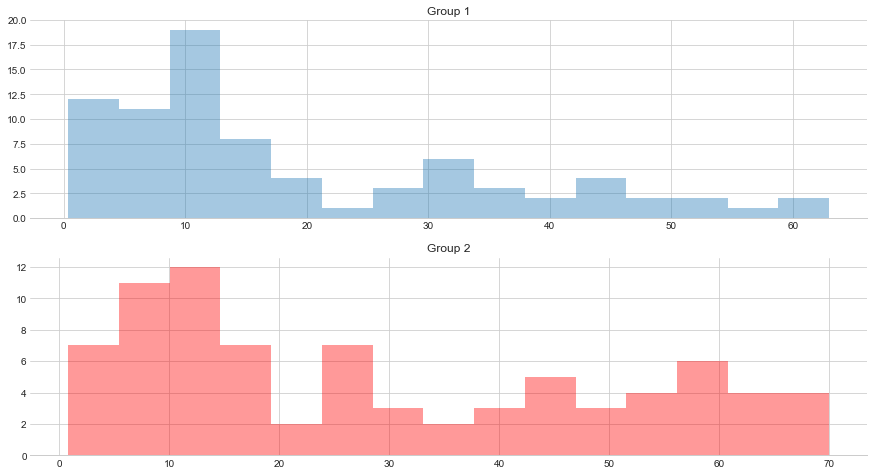

In [43]:
plt.subplots(figsize=(15, 8))
plt.subplot(211)
plt.title('Group 1')
sns.distplot(gr1_arr, kde=False, bins=15)

plt.subplot(212)
plt.title('Group 2')
sns.distplot(gr2_arr, kde=False, bins=15, color='r')
sns.despine(left=True)

### Подбор распределения через критерий Колгоморова-Смирнова и ручной подбор параметров

In [44]:
st.kstest(gr1_arr, 'expon', (0.7, 19)), st.kstest(gr2_arr, 'expon', (3, 29)), st.kstest(groups, 'expon', (1.3, 24))

ValueError: operands could not be broadcast together with shapes (20,) (20,8) 

In [45]:
exp1 = st.expon.rvs(loc=1.3, scale=19, size=1000)
exp2 = st.expon.rvs(loc=3, scale=29, size=1000)
exp_full = st.expon.rvs(loc=1.3, scale=24, size=1000)
groups = np.ravel(np.vstack([gr1_arr,gr2_arr]))

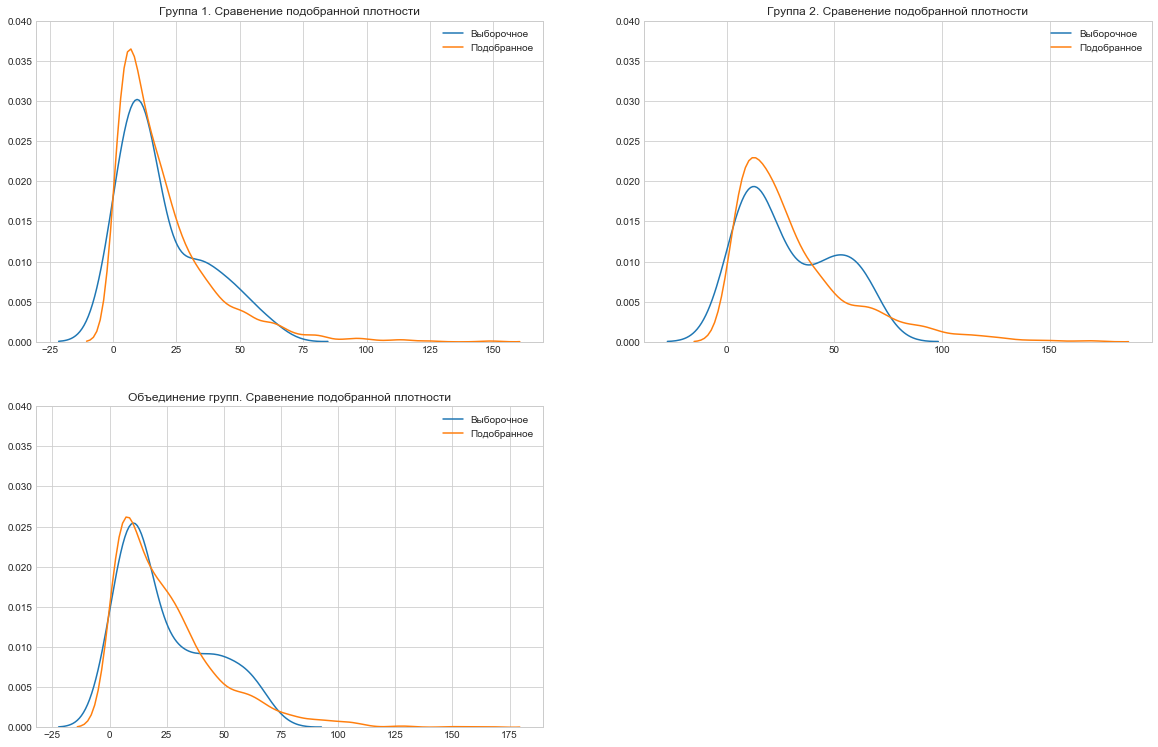

In [46]:
plt.subplots(figsize=(20,13))
plt.subplot(221)
plt.title('Группа 1. Сравенение подобранной плотности')
sns.distplot(gr1_arr, hist=False, label='Выборочное');
sns.distplot(exp1, hist=False, label='Подобранное');
plt.ylim(0, 0.040);
plt.subplot(222)
plt.title('Группа 2. Сравенение подобранной плотности')
sns.distplot(gr2_arr, hist=False, label='Выборочное');
sns.distplot(exp2, hist=False, label='Подобранное');
plt.ylim(0, 0.040);
plt.subplot(223)
plt.title('Объединение групп. Сравенение подобранной плотности')
sns.distplot(groups, hist=False, label='Выборочное');
sns.distplot(exp_full, hist=False, label='Подобранное');
plt.ylim(0, 0.040);

plt.savefig('comparison_hyp.png')

### Побудувати емпіричну функцію розподілу. Якщо в попередньому пункті вдалося підібрати функцію щільності – намалювати графік функції розподілу.

#### Знаходження емпіричної функції розподілу

In [47]:
gr1 = np.copy(gr1_arr)
gr2 = np.copy(gr2_arr)
gr1, gr2 = np.sort(gr1), np.sort(gr2)
ecdf = ECDF(gr1)

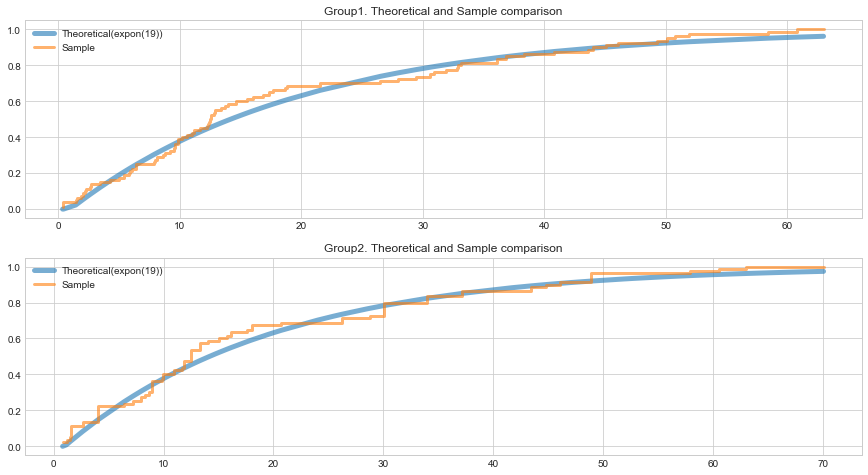

In [48]:
from scipy.stats import logistic,uniform,norm,pearsonr,chi2,expon
from numpy import sqrt,pi,e
pexp1 = expon.cdf(gr1,1,19)
pexp2 = expon.cdf(gr2,1,19)

fig, ax = plt.subplots(figsize=(15,8))
plt.subplot(211)
plt.title('Group1. Theoretical and Sample comparison')
plt.plot(gr1, pexp1, lw=5, alpha=0.6, label='Theoretical(expon(19))')
plt.step(gr1, ecdf(gr1), lw=3, alpha=0.6, label='Sample')
plt.legend()
plt.subplot(212)
plt.title('Group2. Theoretical and Sample comparison')
plt.plot(gr2, pexp2, lw=5, alpha=0.6, label='Theoretical(expon(19))')
plt.step(gr2, ecdf(gr2), lw=3, alpha=0.6, label='Sample')

plt.legend();
plt.savefig('comparison.png')

### Порівняти середні значення у групах за t-критерієм Стьюдента на рівні 0.01

#### An Independent Samples t-test compares the means for two groups.

#### 1. Determine a null and alternate hypothesis.

The null hypothesis will state that the two populations being tested have no statistically significant difference. The alternate hypothesis will state that there is one present. In this example we can say that:

#### 2. Assign sample data

In [49]:
a = gr2
b = gr1
N=80

#### 3. Determine a confidence interval and degrees of freedom

This is what we call alpha (α). The typical value of α is 0.05. This means that there is 95% confidence that the conclusion of this test will be valid. The degree of freedom can be calculated by the the following formula:

df = n_x + n_y - 2

In [50]:
## Compare with the critical t-value
#Degrees of freedom
df = gr1.shape[0] + gr2.shape[0] - 2

#### 4. Calculate the t-statistic

t-statistic can be calculated using the below formula:

![title](t-test.png)


In [51]:
## Calculate the Standard Deviation
#Calculate the variance to get the standard deviation

#For unbiased max likelihood estimate we have to divide the var by N-1, and therefore the parameter ddof = 1
var_a = a.var(ddof=1)
var_b = b.var(ddof=1)

#std deviation
s = np.sqrt((var_a + var_b)/2)
s

## Calculate the t-statistics
t = (a.mean() - b.mean())/(s*np.sqrt(2/N))

To calculate the critical t-value, we need 2 things, the chosen value of alpha and the degrees of freedom. The formula of critical t-value is complex but it is fixed for a fixed pair of degree of freedom and value of alpha. We therefore use a table to calculate the critical t-value:

6. Compare the critical t-values with the calculated t statistic

In [52]:
#p-value after comparison with the t 
p = 1 - st.t.cdf(t,df=df)

In [53]:
print("t = " + str(t))
print("p = " + str(2*p))
#Note that we multiply the p value by 2 because its a twp tail t-test
### You can see that after comparing the t statistic with the critical t value (computed internally) we get a good p value of 0.0005 and thus we reject the null hypothesis and thus it proves that the mean of the two distributions are different and statistically significant.


## Cross Checking with the internal scipy function
t2, p2 = st.ttest_ind(a,b, equal_var = False)
print("t = " + str(t2))
print("p = " + str(p2))

t = 3.2685001923856536
p = 0.0013267449018197208
t = 3.2685001923856536
p = 0.001343892460708955
